### 일단 내가 봤을 때 피드백의 가장 중요한 부분은

'데이터를 봐야 한다'는 거다. 일례로, ch09 전자레인지의 경우, 

하루종일 전자레인지를 쓰는 것이 아니다. 즉, active되어 있는 시점에 대해 active power 분석을 하든지 해야 한다. 

### 그리고 가장 중요한 것은 전자기기별 특징을 뽑아내는 것이다. 

active되어 있는 부분만 추려서 분석해보는 것이 가장 좋은 방법이다.

In [2]:
'''
필요한 라이브러리: 
    기본적으로 pandas, numpy 필요하고 시각화를 위해 matplotlib.pyplot도 불러온 다음
    darts 설치 필요하고, darts에서 TimeSeries, 그리고 Path도 따로 필요함 (없을 시 설치 필요)
'''
import darts
from pathlib import Path
from darts import TimeSeries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### **근데 어쩌면 fft가 핵심이 아닐 수도 있다**

교수님꼐서는 '기기별로 추출할 수 있는 특성들을 살펴보라'고 하셨다. 무조건 fft를 돌리라는 게 아니라, 

active되어 있는 시간만 보면서 그 기기가 나타내는 특성을 보라는 것. 

애초에 fft가 왜 나왔는지를 생각해보면, '전력-시간'을 '전력-주파수'로 변환하는 것에서 나왔다. fft가 유의미한 결과를 보이지 않았다면, 차라리 '전력-주파수' 그래프에 집중할 것이 아니라, '전력-시간'그래프로 다시 돌아가서 해당 그래프를 관찰하는 것이 답일 수도 있다. 

In [37]:
# ch09 의 경우에 대해서 계속 살펴보자.

'''
코드설명:
    pkl 파일의 형식 처리 및 fft 실행 코드는 대부분 함수로 선언하여 처리한다. 
함수정리:
    pkl 파일 데이터프레임 형식 처리 함수: pkl_todf(file)
    여러 개 df에 대한 fft 실행 함수: fft_dfs(df,idx)
    하나의 df에 대한 fft 실행 함수: fft_df(df)
'''
# 우선 ts.pkl 파일을 데이터프레임 형식으로 바꾸는 pkl_todf 함수를 선언한다. (뒤에서도 계속 이 함수 이용할 것임.)
# 함수 선언
def pkl_todf(pkl_path: str | Path) -> pd.DataFrame:
    pkl_path = Path(pkl_path)
    if not pkl_path.exists():
        raise FileNotFoundError(pkl_path)

    ts: TimeSeries = TimeSeries.from_pickle(str(pkl_path))
    return ts.to_dataframe()

# 10개의 ch09 파일 가져와서 데이터프레임으로 변환
if __name__ == "__main__":
    folder_path = Path("C:/Users/UserPC/OneDrive/00 MATRIX 컨퍼런스/ch09")
    
    pkl_files = sorted(folder_path.glob("*.ts.pkl"))[:10]           

    for i, file in enumerate(pkl_files, start=1):           # 이때 10개의 파일을 각각 df1, df2, ..., df10이라는 이름으로 각각 저장한다.
        globals()[f"df{i}"] = pkl_todf(file)

    display(df1)

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 00:00:00.000,0.26,217.0,0.027,5.85,0.0
2023-10-02 00:00:00.100,0.11,217.0,0.027,5.86,0.0
2023-10-02 00:00:00.200,0.26,217.0,0.027,5.85,0.0
2023-10-02 00:00:00.300,0.33,217.0,0.027,5.85,0.0
2023-10-02 00:00:00.400,0.24,217.0,0.027,5.85,0.0
...,...,...,...,...,...
2023-10-02 23:59:59.500,0.28,219.0,0.027,5.91,0.0
2023-10-02 23:59:59.600,0.29,219.0,0.027,5.91,0.0
2023-10-02 23:59:59.700,0.29,219.0,0.027,5.91,0.0


In [38]:
# 혹시 모르니 fft_dfs(df,idx) 함수와 fft_df(df) 함수는 미리 선언해두자.
def fft_dfs(df, idx):

    df.index = pd.to_datetime(df.index) # 인덱스를 datetime으로 변환
    signal = df["active_power"].values  # 분석은 active_power 열을 기반으로 한다. 

    time_diffs = df.index.to_series().diff().dt.total_seconds().dropna().values # 샘플링 주기 계산
    sampling_interval = np.median(time_diffs)
    fs = 1 / sampling_interval  

    # FFT 수행
    n = len(signal)
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, d=1/fs)
    power_spectrum = np.abs(fft_result)**2 / n

    mask = freqs > 0        # 양의 주파수만 추출
    freqs = freqs[mask]
    power_spectrum = power_spectrum[mask]

    plt.figure(figsize=(10, 4))
    plt.plot(freqs, power_spectrum, color='blue')
    plt.title(f"Power Spectrum of active_power (df{idx})")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def fft_df(df):
    df.index = pd.to_datetime(df.index)
    signal = df["active_power"].values

    time_diffs = df.index.to_series().diff().dt.total_seconds().dropna().values
    sampling_interval = np.median(time_diffs)
    fs = 1 / sampling_interval  # 샘플링 주파수

    # FFT 수행
    n = len(signal)
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, d=1/fs)
    power_spectrum = np.abs(fft_result)**2 / n

    mask = freqs > 0        # 양의 주파수만 추출
    freqs = freqs[mask]
    power_spectrum = power_spectrum[mask]

    plt.figure(figsize=(10, 4))
    plt.plot(freqs, power_spectrum, color='blue')
    plt.title("Power Spectrum of active_power (df1_active)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### **그리고 이제 각 가정별로 active한 시간대만 추려서 '전력-시간'그래프를 살펴보자.**

여기서 '전력-시간'그래프는 원본데이터(전처리 한 데이터) 기준으로 그린 것이고, 초록색으로 표시하였다. 

비교해서 볼 '전력-주파수' 그래프는 fft 실행의 결과이고, 파란색으로 표시하였다. 

In [39]:
df1_active = df1[df1['active_inactive'] == 1]
df1_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 09:47:58.700,0.26,213.0,0.026,5.53,1.0
2023-10-02 09:47:58.800,308.21,213.0,2.099,323.87,1.0
2023-10-02 09:47:58.900,207.58,213.0,2.536,498.69,1.0
2023-10-02 09:47:59.000,188.98,213.0,2.628,526.90,1.0
2023-10-02 09:47:59.100,173.04,213.0,2.655,538.39,1.0
...,...,...,...,...,...
2023-10-02 20:23:56.300,1105.44,213.0,5.618,458.19,1.0
2023-10-02 20:23:56.400,1105.54,213.0,5.624,461.27,1.0
2023-10-02 20:23:56.500,1105.07,213.0,5.623,461.85,1.0


In [73]:
df1_active.index = pd.to_datetime(df1_active.index)

df1_09 = df1_active[df1_active.index.hour == 9]
df1_20 = df1_active[df1_active.index.hour == 20]

df1_09

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 09:47:58.700,0.26,213.0,0.026,5.53,1.0
2023-10-02 09:47:58.800,308.21,213.0,2.099,323.87,1.0
2023-10-02 09:47:58.900,207.58,213.0,2.536,498.69,1.0
2023-10-02 09:47:59.000,188.98,213.0,2.628,526.90,1.0
2023-10-02 09:47:59.100,173.04,213.0,2.655,538.39,1.0
...,...,...,...,...,...
2023-10-02 09:59:59.500,1049.84,211.0,5.305,388.32,1.0
2023-10-02 09:59:59.600,1047.70,211.0,5.303,392.86,1.0
2023-10-02 09:59:59.700,1049.40,211.0,5.302,387.68,1.0


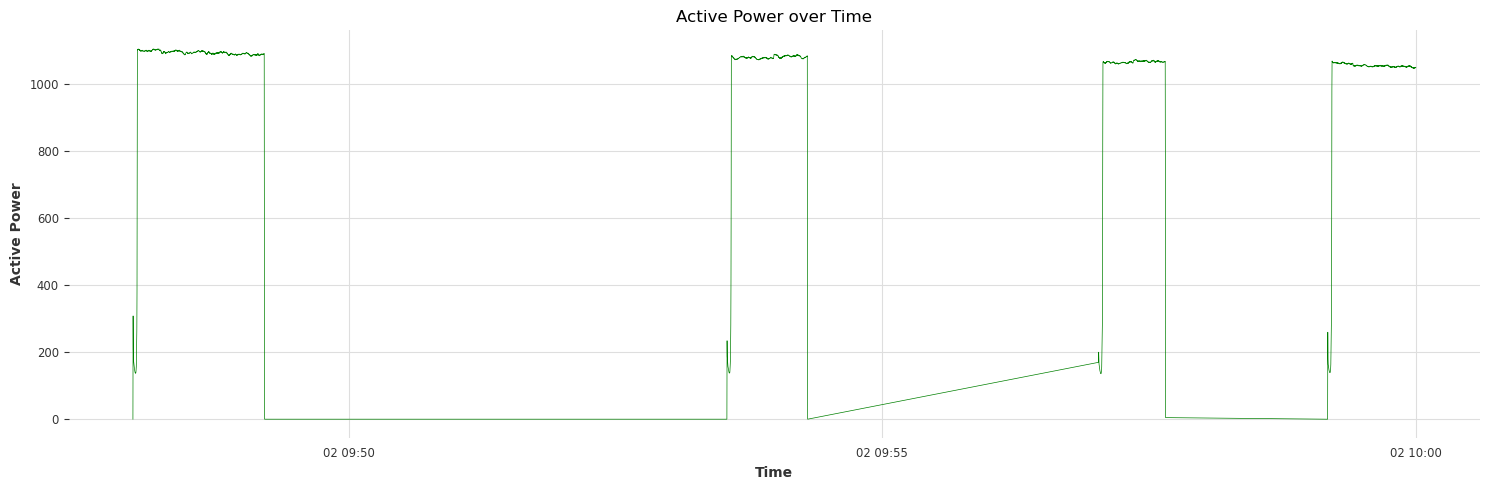

In [74]:
# 시간 순으로 정렬 (선택 사항)
df1_09 = df_09.sort_index()

# 선그래프 그리기
plt.figure(figsize=(15, 5))
plt.plot(df1_09.index, df1_09['active_power'], color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.title('Active Power over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

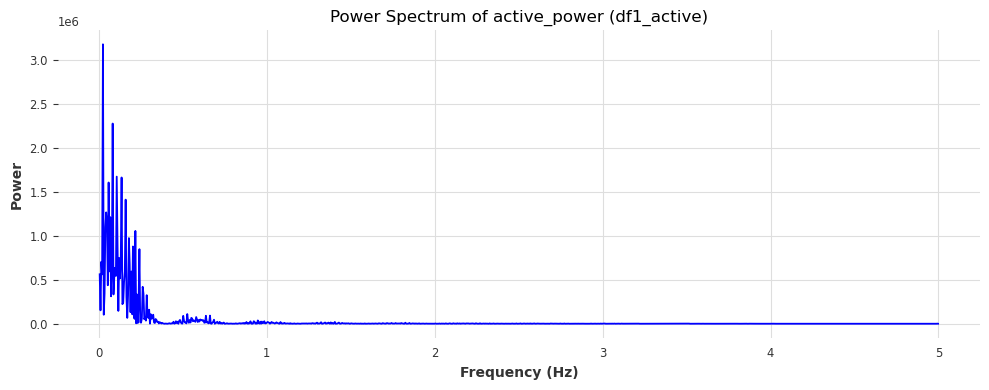

In [75]:
fft_df(df1_09)

In [69]:
df3_active = df3[df3['active_inactive']==1]
df3_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 12:07:35.900,46.26,227.0,0.230,24.21,1.0
2023-10-02 12:07:36.000,282.76,227.0,1.502,190.52,1.0
2023-10-02 12:07:36.100,252.72,227.0,2.433,491.08,1.0
2023-10-02 12:07:36.200,206.02,227.0,4.067,899.93,1.0
2023-10-02 12:07:36.300,198.52,227.0,4.160,923.22,1.0
...,...,...,...,...,...
2023-10-02 14:27:58.100,21.38,230.0,0.094,3.21,1.0
2023-10-02 14:27:58.200,21.32,230.0,0.094,3.59,1.0
2023-10-02 14:27:58.300,21.42,230.0,0.094,2.93,1.0


In [76]:
df3_12 = df3_active[df3_active.index.hour == 12]
df3_14 = df3_active[df3_active.index.hour == 14]

df3_12

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 12:07:35.900,46.26,227.0,0.230,24.21,1.0
2023-10-02 12:07:36.000,282.76,227.0,1.502,190.52,1.0
2023-10-02 12:07:36.100,252.72,227.0,2.433,491.08,1.0
2023-10-02 12:07:36.200,206.02,227.0,4.067,899.93,1.0
2023-10-02 12:07:36.300,198.52,227.0,4.160,923.22,1.0
...,...,...,...,...,...
2023-10-02 12:14:13.200,1133.49,226.0,5.481,499.59,1.0
2023-10-02 12:14:13.300,1135.17,226.0,5.481,495.76,1.0
2023-10-02 12:14:13.400,1133.12,226.0,5.475,497.07,1.0


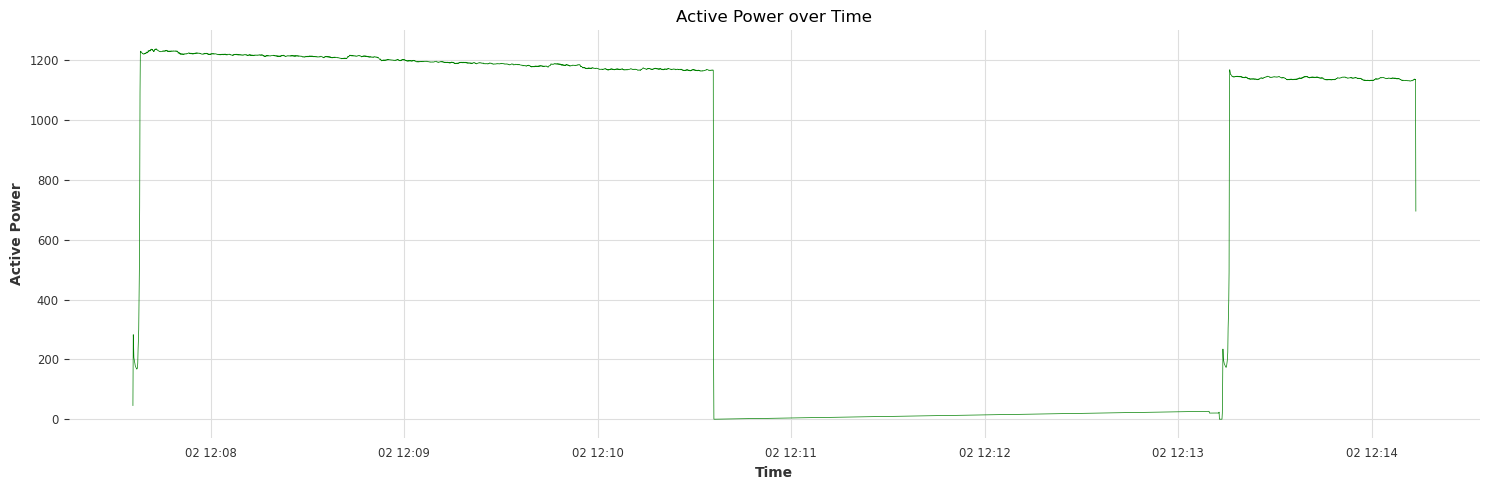

In [77]:
# 시간 순으로 정렬 (선택 사항)
df3_12 = df3_12.sort_index()

# 선그래프 그리기
plt.figure(figsize=(15, 5))
plt.plot(df3_12.index, df3_12['active_power'], color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.title('Active Power over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

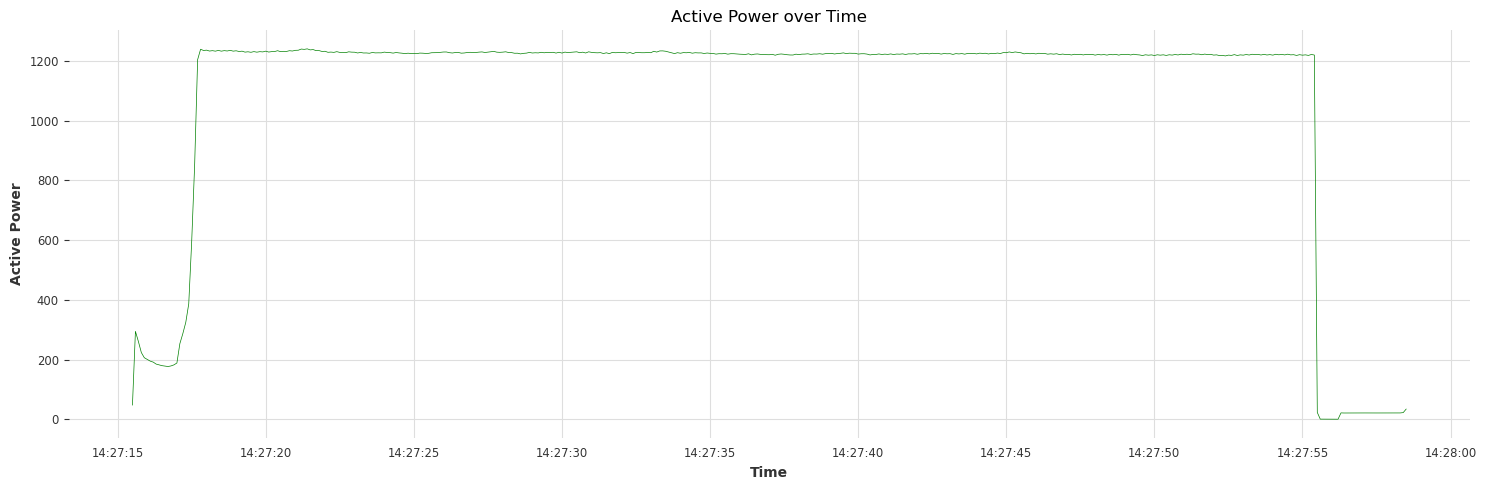

In [78]:
# 시간 순으로 정렬 (선택 사항)
df3_14 = df3_14.sort_index()

# 선그래프 그리기
plt.figure(figsize=(15, 5))
plt.plot(df3_14.index, df3_14['active_power'], color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.title('Active Power over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
df5_active = df5[df5['active_inactive']==1]
df5_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 11:27:16.900,8.46,215.0,0.074,13.47,1.0
2023-10-02 11:27:17.000,25.67,215.0,0.129,10.50,1.0
2023-10-02 11:27:17.100,20.61,215.0,0.101,6.84,1.0
2023-10-02 11:27:17.200,20.60,215.0,0.098,4.43,1.0
2023-10-02 11:27:17.300,20.56,215.0,0.098,4.61,1.0
...,...,...,...,...,...
2023-10-02 14:08:13.700,13.15,215.0,0.096,15.91,1.0
2023-10-02 14:08:13.800,13.32,215.0,0.096,15.77,1.0
2023-10-02 14:08:13.900,13.17,215.0,0.096,15.89,1.0


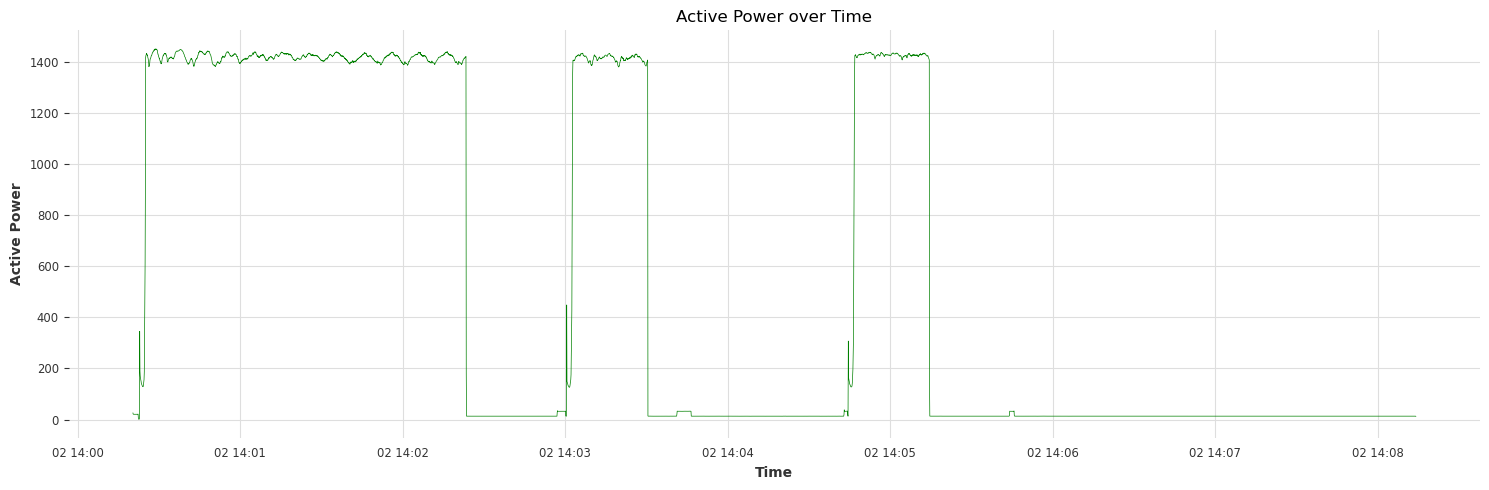

In [83]:
df5_11 = df5_active[df5_active.index.hour == 11]
df5_14 = df5_active[df5_active.index.hour == 14]

df5_14 = df5_14.sort_index()

plt.figure(figsize=(15, 5))
plt.plot(df5_14.index, df5_14['active_power'], color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.title('Active Power over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

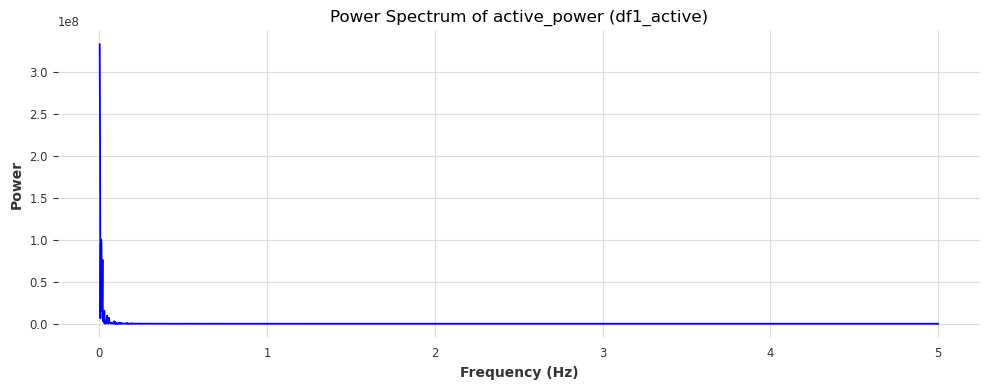

In [84]:
fft_df(df5_14)

### **'전력-주파수' 그래프에서는 안 보이던 특징들이 '전력-시간'그래프에서는 보이기 시작했다.**

그러면, 차라리 '동특성', 즉 '기기별로 보이는 기기 고유만의 특성'을 '전력-시간'그래프로 정의할 수 있지 않을까?

위에서 살펴본 것은 ch09 전자레인지의 경우이고, 이와 비교하기 위해 ch07 헤어드라이기의 경우를 살펴보면 다음과 같다. 

### **헤어드라이기는 전자레인지와 다를까?**

In [ ]:
# ch07 파일 가져와서 데이터프레임으로 변환

if __name__ == "__main__":
    folder_path = Path("C:/Users/UserPC/OneDrive/00 MATRIX 컨퍼런스/ch07")
    
    pkl_files = sorted(folder_path.glob("*.ts.pkl"))[:10]           

    for i, file in enumerate(pkl_files, start=1):           # 이때 10개의 파일을 각각 df1, df2, ..., df10이라는 이름으로 각각 저장한다.
        globals()[f"df{i}"] = pkl_todf(file)

    display(df1)

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 00:00:00.000,0.00,218.0,0.000,0.00,0.0
2023-10-02 00:00:00.100,0.21,218.0,0.001,0.06,0.0
2023-10-02 00:00:00.200,0.00,218.0,0.000,0.00,0.0
2023-10-02 00:00:00.300,0.00,217.0,0.000,0.00,0.0
2023-10-02 00:00:00.400,0.00,218.0,0.000,0.00,0.0
...,...,...,...,...,...
2023-10-02 23:59:59.500,0.21,219.0,0.001,0.06,0.0
2023-10-02 23:59:59.600,0.21,219.0,0.001,0.06,0.0
2023-10-02 23:59:59.700,0.21,219.0,0.001,0.06,0.0


In [94]:
df1_active = df1[df1['active_inactive']==1]
df1_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 11:51:05.300,131.51,214.0,1.487,289.77,1.0
2023-10-02 11:51:05.400,40.81,214.0,1.683,357.84,1.0
2023-10-02 11:51:05.500,1.80,214.0,0.499,106.77,1.0
2023-10-02 11:51:05.600,6.17,214.0,0.274,58.31,1.0
2023-10-02 11:51:05.700,16.45,214.0,0.180,34.83,1.0
...,...,...,...,...,...
2023-10-02 11:53:21.400,1.08,215.0,2.161,464.61,1.0
2023-10-02 11:53:21.500,136.95,215.0,0.637,1.17,1.0
2023-10-02 11:53:21.600,74.39,215.0,0.346,0.00,1.0


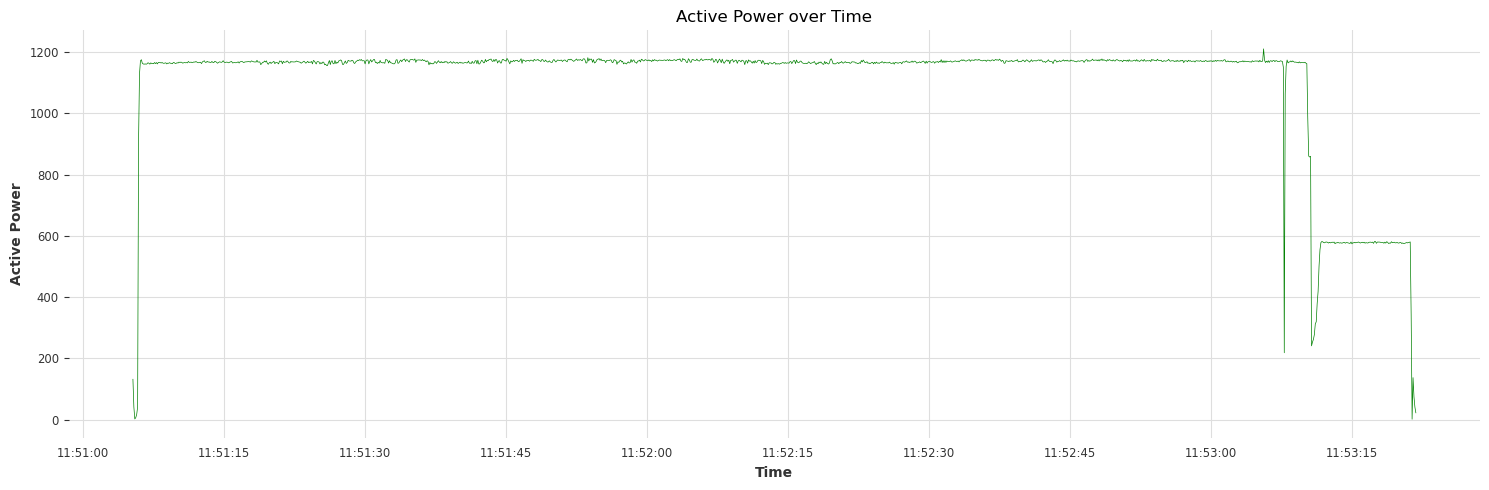

In [95]:
df1_active = df1_active.sort_index()

plt.figure(figsize=(15, 5))
plt.plot(df1_active.index, df1_active['active_power'], color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.title('Active Power over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [96]:
df2_active = df2[df2['active_inactive']==1]
df2_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 09:22:06.400,400.86,213.0,1.882,2.19,1.0
2023-10-02 09:22:06.500,799.26,211.0,3.788,3.58,1.0
2023-10-02 09:22:06.600,1097.25,210.0,5.225,0.00,1.0
2023-10-02 09:22:06.700,1162.87,209.0,5.564,3.74,1.0
2023-10-02 09:22:06.800,1183.77,209.0,5.664,3.77,1.0
...,...,...,...,...,...
2023-10-02 09:23:48.100,0.36,213.0,2.473,526.75,1.0
2023-10-02 09:23:48.200,286.05,213.0,1.343,2.27,1.0
2023-10-02 09:23:48.300,0.02,214.0,0.729,156.01,1.0


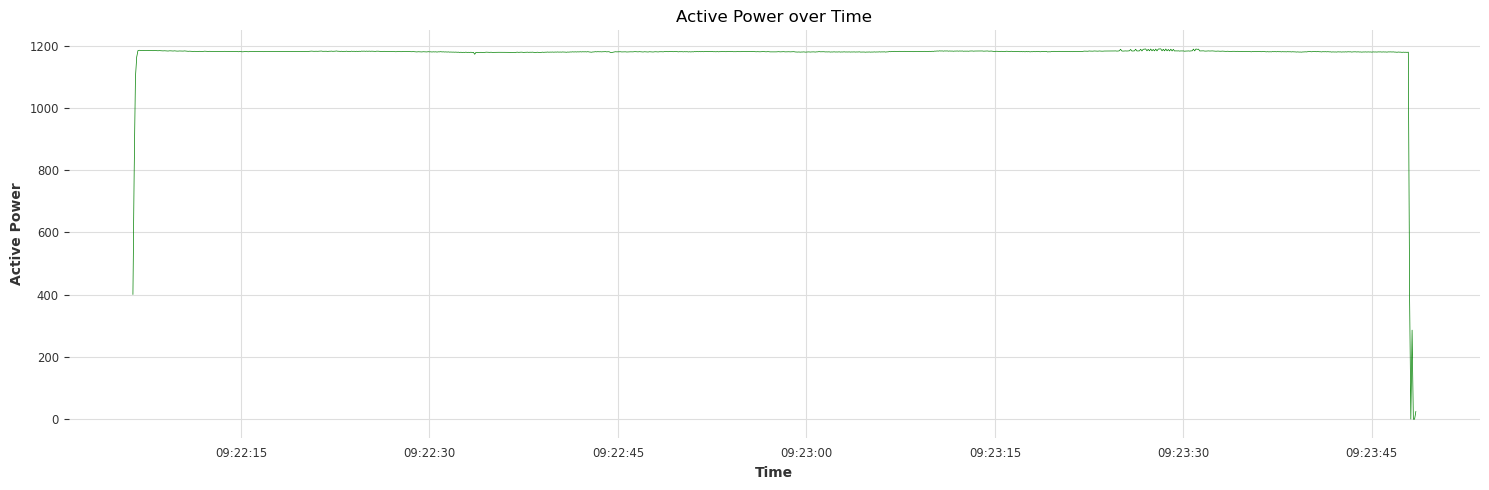

In [97]:
df2_active = df2_active.sort_index()

plt.figure(figsize=(15, 5))
plt.plot(df2_active.index, df2_active['active_power'], color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.title('Active Power over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [98]:
df3_active = df3[df3['active_inactive']==1]
df3_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 09:31:39.400,318.76,229.0,1.921,303.17,1.0
2023-10-02 09:31:39.500,1420.56,227.0,6.258,4.13,1.0
2023-10-02 09:31:39.600,1489.79,226.0,6.592,2.44,1.0
2023-10-02 09:31:39.700,1512.22,225.0,6.721,3.89,1.0
2023-10-02 09:31:39.800,1524.60,225.0,6.776,0.00,1.0
...,...,...,...,...,...
2023-10-02 19:28:21.300,1433.22,223.0,6.427,1.69,1.0
2023-10-02 19:28:21.400,1432.10,223.0,6.422,4.15,1.0
2023-10-02 19:28:21.500,1433.22,223.0,6.427,1.69,1.0


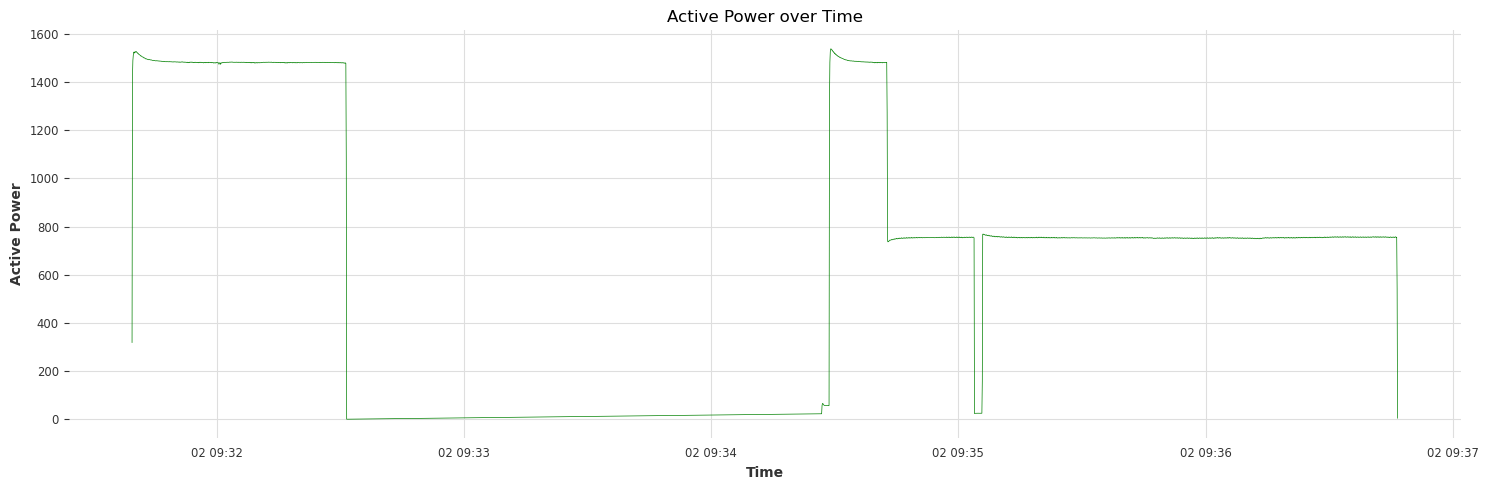

In [101]:
df3_9 = df3_active[df3_active.index.hour == 9]
df3_19 = df3_active[df3_active.index.hour == 19]

df3_9 = df3_9.sort_index()

plt.figure(figsize=(15, 5))
plt.plot(df3_9.index, df3_9['active_power'], color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.title('Active Power over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

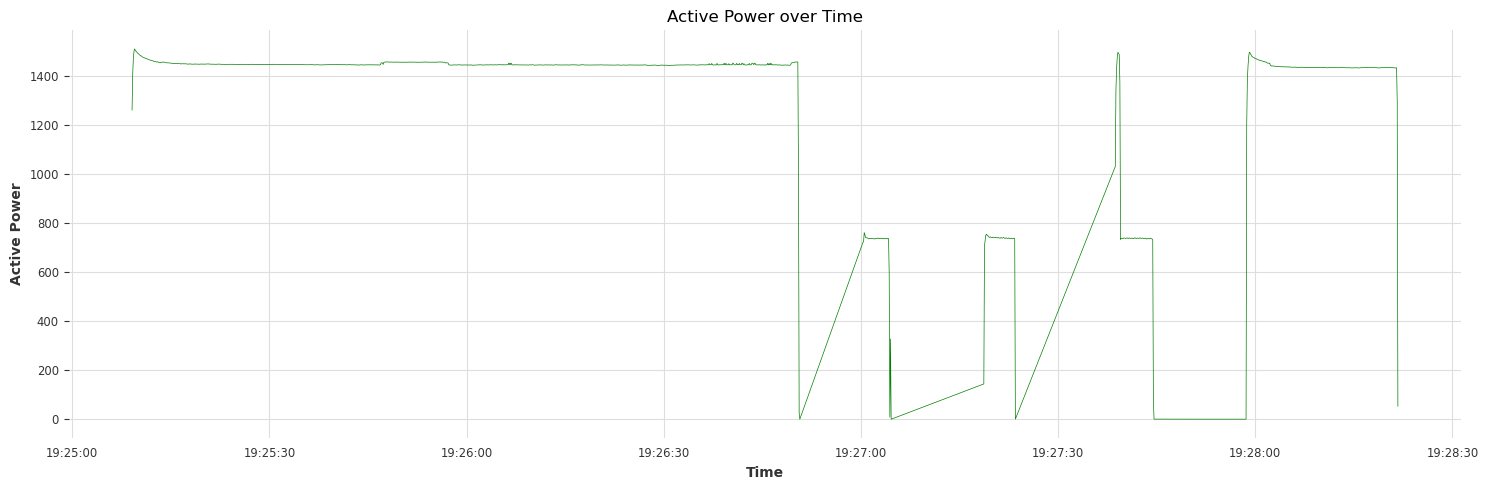

In [102]:
df3_19 = df3_19.sort_index()

plt.figure(figsize=(15, 5))
plt.plot(df3_19.index, df3_19['active_power'], color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.title('Active Power over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

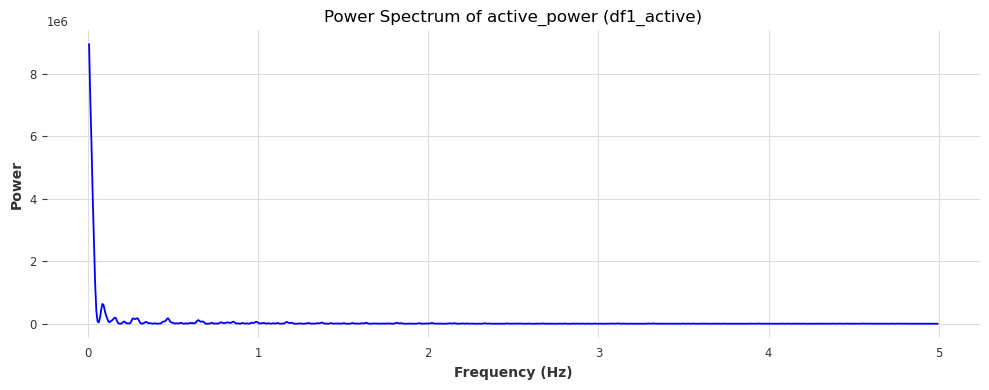

In [103]:
fft_df(df3_19)

In [104]:
df5_active = df5[df5['active_inactive']==1]
df5_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 13:23:45.400,0.21,215.0,0.001,0.05,1.0
2023-10-02 13:23:45.500,28.31,215.0,0.664,139.92,1.0
2023-10-02 13:23:45.600,57.10,215.0,1.296,272.73,1.0
2023-10-02 13:23:45.700,2.23,215.0,0.707,151.99,1.0
2023-10-02 13:23:45.800,10.57,215.0,0.400,85.35,1.0
...,...,...,...,...,...
2023-10-02 13:25:05.000,393.47,215.0,2.641,409.38,1.0
2023-10-02 13:25:05.100,402.75,215.0,2.702,418.66,1.0
2023-10-02 13:25:05.200,8.00,215.0,1.731,372.08,1.0


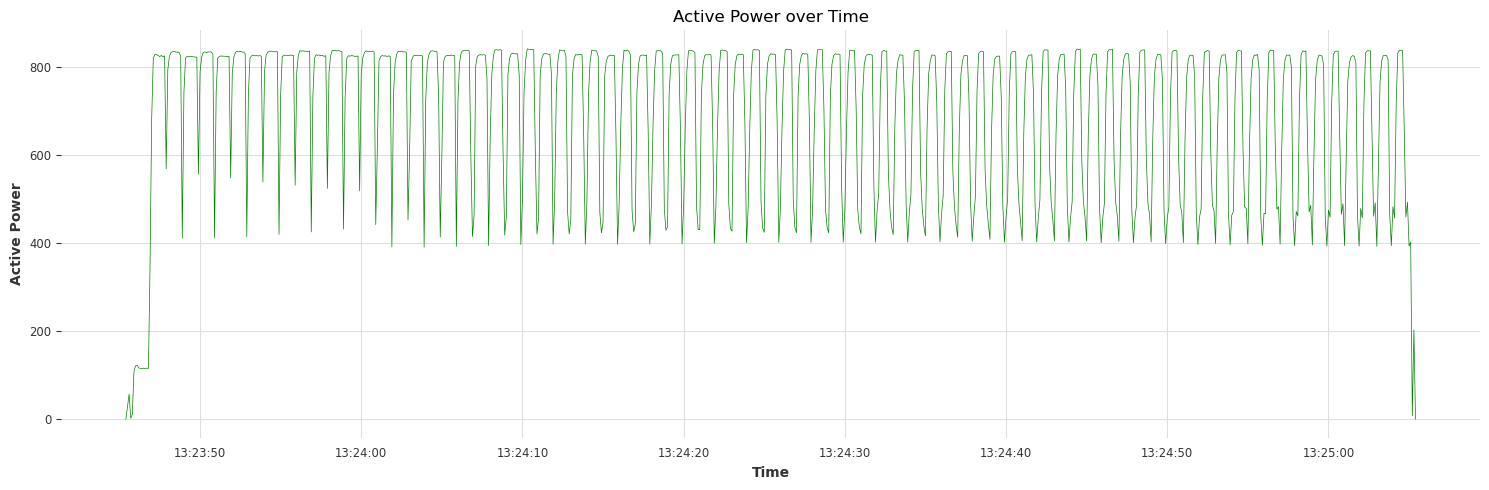

In [105]:
df5_active = df5_active.sort_index()

plt.figure(figsize=(15, 5))
plt.plot(df5_active.index, df5_active['active_power'], color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.title('Active Power over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [106]:
df6_active = df6[df6['active_inactive']==1]
df6_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 18:58:51.500,0.00,223.0,0.000,0.00,1.0
2023-10-02 18:58:51.600,173.84,222.0,1.030,148.54,1.0
2023-10-02 18:58:51.700,435.58,222.0,2.041,124.79,1.0
2023-10-02 18:58:51.800,331.72,222.0,1.595,123.86,1.0
2023-10-02 18:58:51.900,326.21,222.0,1.511,78.16,1.0
...,...,...,...,...,...
2023-10-02 22:28:44.400,407.22,223.0,6.798,1460.24,1.0
2023-10-02 22:28:44.500,455.16,226.0,2.014,1.91,1.0
2023-10-02 22:28:44.600,247.24,226.0,1.094,1.41,1.0


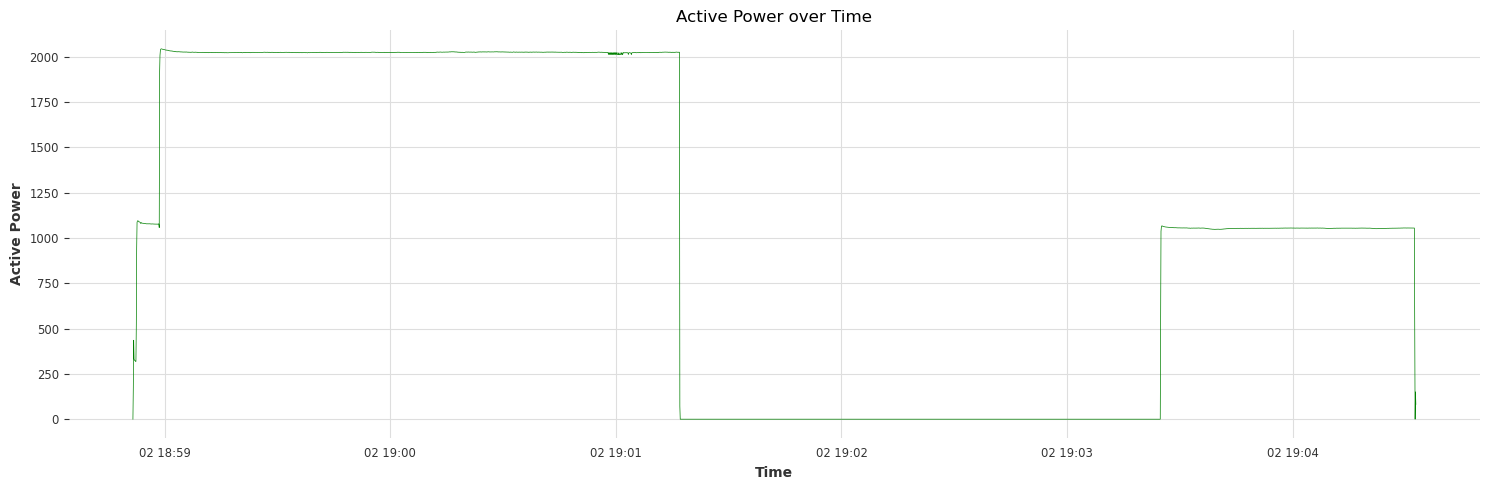

In [108]:
df6_18 = df6_active[df6_active.index.hour==18]
df6_19 = df6_active[df6_active.index.hour==19]
df6_18to19 = pd.concat([df6_18,df6_19]).sort_index()

plt.figure(figsize=(15, 5))
plt.plot(df6_18to19.index, df6_18to19['active_power'], color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.title('Active Power over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

헤어드라이기는 사실상 공통된 특징이 없다고 볼 수 있다. 

### **이번에는 ch04 전기포트의 경우를 보자.**

In [109]:
if __name__ == "__main__":
    folder_path = Path("C:/Users/UserPC/OneDrive/00 MATRIX 컨퍼런스/ch04")
    
    pkl_files = sorted(folder_path.glob("*.ts.pkl"))[:10]           

    for i, file in enumerate(pkl_files, start=1):           # 이때 10개의 파일을 각각 df1, df2, ..., df10이라는 이름으로 각각 저장한다.
        globals()[f"df{i}"] = pkl_todf(file)

    display(df1)

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 00:00:00.000,0.00,217.0,0.000,0.00,0.0
2023-10-02 00:00:00.100,0.04,217.0,0.001,0.21,0.0
2023-10-02 00:00:00.200,0.07,217.0,0.001,0.21,0.0
2023-10-02 00:00:00.300,0.00,217.0,0.000,0.00,0.0
2023-10-02 00:00:00.400,0.06,217.0,0.002,0.43,0.0
...,...,...,...,...,...
2023-10-02 23:59:59.500,0.00,218.0,0.000,0.00,0.0
2023-10-02 23:59:59.600,0.00,219.0,0.000,0.00,0.0
2023-10-02 23:59:59.700,0.00,218.0,0.000,0.00,0.0


In [110]:
df1_active = df1[df1['active_inactive']==1]
df1_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 11:09:43.900,0.05,214.0,0.001,0.21,1.0
2023-10-02 11:09:44.000,804.64,214.0,3.760,0.00,1.0
2023-10-02 11:09:44.100,1458.19,213.0,6.846,4.83,1.0
2023-10-02 11:09:44.200,1609.92,212.0,7.594,5.08,1.0
2023-10-02 11:09:44.300,1652.54,212.0,7.795,0.00,1.0
...,...,...,...,...,...
2023-10-02 11:34:03.400,218.28,214.0,1.020,0.00,1.0
2023-10-02 11:34:03.500,0.00,214.0,0.554,118.56,1.0
2023-10-02 11:34:03.600,0.00,214.0,0.301,64.41,1.0


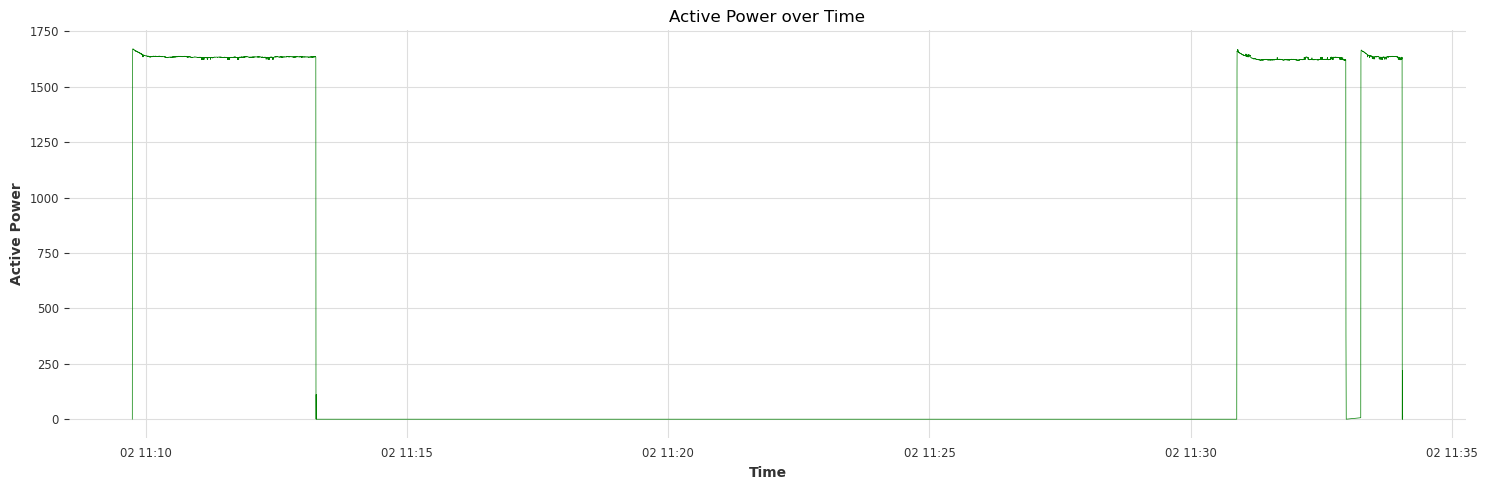

In [111]:
df1_active = df1_active.sort_index()
plt.figure(figsize=(15, 5))
plt.plot(df1_active.index, df1_active['active_power'], color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.title('Active Power over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [118]:
df8_active = df8[df8['active_inactive']==1]
df8_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 09:19:28.400,0.00,216.0,0.000,0.00,1.0
2023-10-02 09:19:28.500,1257.76,213.0,5.905,3.55,1.0
2023-10-02 09:19:28.600,1516.87,211.0,7.189,5.23,1.0
2023-10-02 09:19:28.700,1587.35,211.0,7.523,3.09,1.0
2023-10-02 09:19:28.800,1608.66,211.0,7.624,3.59,1.0
...,...,...,...,...,...
2023-10-02 09:21:27.700,33.72,212.0,4.666,988.62,1.0
2023-10-02 09:21:27.800,0.03,214.0,2.534,542.28,1.0
2023-10-02 09:21:27.900,0.02,214.0,1.376,294.46,1.0


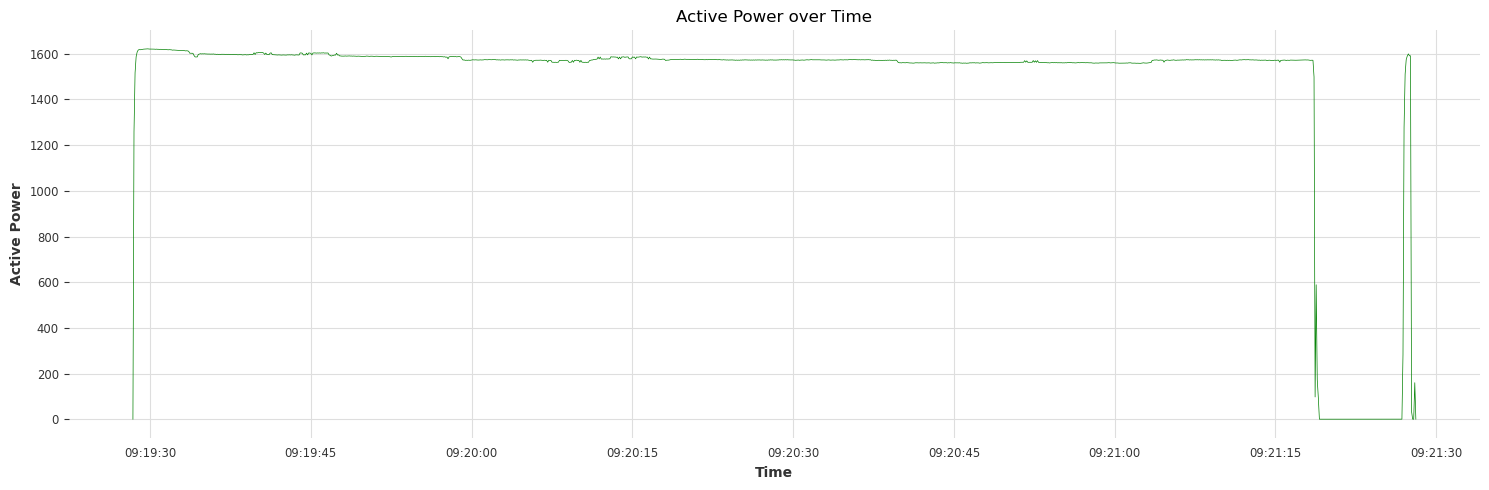

In [119]:
df8_active = df8_active.sort_index()
plt.figure(figsize=(15, 5))
plt.plot(df8_active.index, df8_active['active_power'], color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.title('Active Power over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [121]:
df10_active = df10[df10['active_inactive']==1]
df10_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 13:34:07.600,0.00,216.0,0.000,0.00,1.0
2023-10-02 13:34:07.700,945.35,215.0,4.397,3.07,1.0
2023-10-02 13:34:07.800,1628.38,213.0,7.645,4.04,1.0
2023-10-02 13:34:07.900,1841.81,213.0,8.647,1.92,1.0
2023-10-02 13:34:08.000,1845.88,212.0,8.707,3.84,1.0
...,...,...,...,...,...
2023-10-02 13:35:30.900,135.68,214.0,5.895,1254.21,1.0
2023-10-02 13:35:31.000,0.07,216.0,3.203,691.85,1.0
2023-10-02 13:35:31.100,203.90,216.0,0.944,1.28,1.0


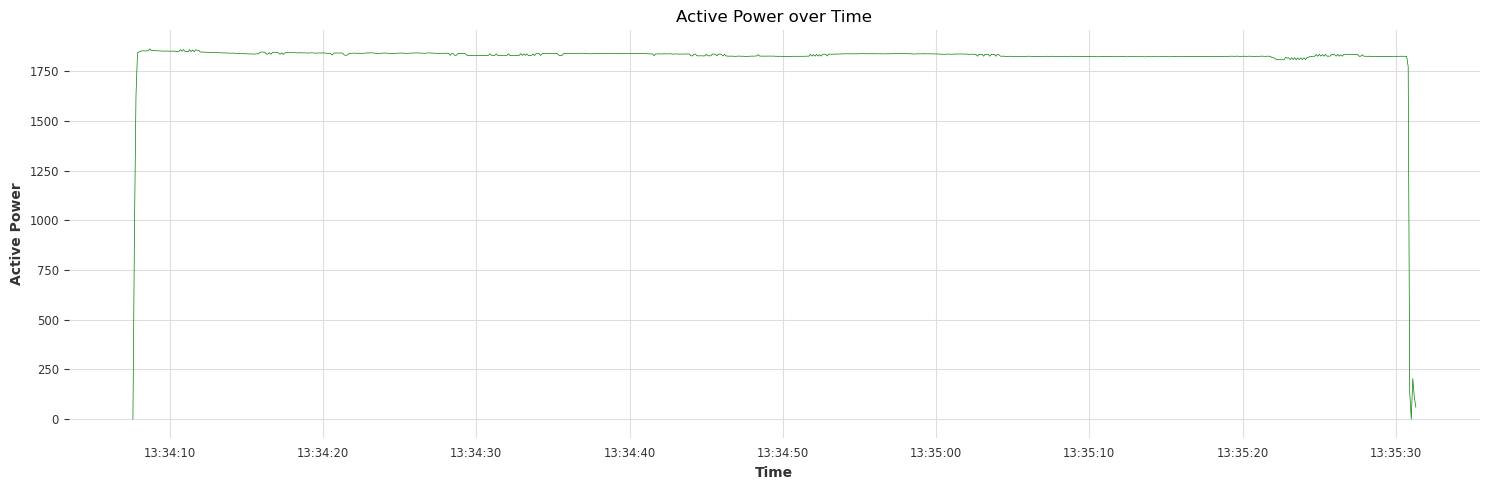

In [122]:
df10_active = df10_active.sort_index()
plt.figure(figsize=(15, 5))
plt.plot(df10_active.index, df10_active['active_power'], color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.title('Active Power over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

### **전기포트도 전자레인지와 같이 일종의 특징이 있음**

따라서 fft를 통해 '전력-주파수'를 보는 것보다, 기존 데이터를 통해 '전력-시간'그래프를 보는 것이 훨씬 더 유의미하고, 효율적임. 

fft를 통해 '전력-주파수' 그래프로 변환하여도 아무런 쓸모가 없다. 즉, fft를 통해 유의미한 모델 피쳐를 추출해낼수 없다. 가 결론임.

왜냐하면 위의 코드에서도 볼 수 있듯이, '전자레인지'와 '전기포트'는 '전력-시간'상의 그래프에서 조금씩은 다른 특징을 보이지만 fft는 이를 잡아낼 수 없기 때문.

### **그렇다고 우리가 22개의 가정 기기에 대해 하나하나 '전력-시간'그래프를 관찰하고 있어야 하나? 그건 아님**

어차피 우리가 가진 데이터가 '전력'에 대한 시계열 데이터이기 때문에, 교수님 말씀대로 얘를 컴퓨터에 때려버린다면 딥러닝이 알아서 각 기기의 특성을 학습할 것임.

따라서 우리는 

- '전력-시간'그래프를 통한 각 기기의 특성을 그래프로 시각화 하는 부분과
- 이를 잘 학습할 수 있는 모델 구축

에 집중하는 것이 좋아 보인다. 